In [14]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

In [15]:
IMAGE_SIZE = [100,100] 


epochs = 10
batch_size = 32


covid_path = 'dataset/Covid19 Positive/output'
noncovid_path = 'dataset/Covid19 Negative/output'


covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [16]:

covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(100,100))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')

for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(100,100))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

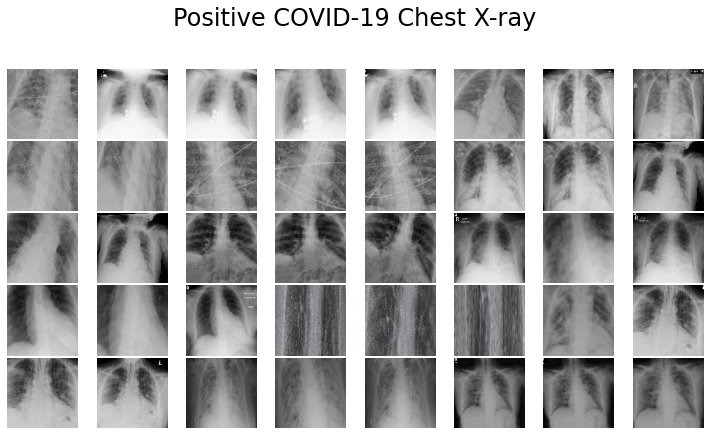

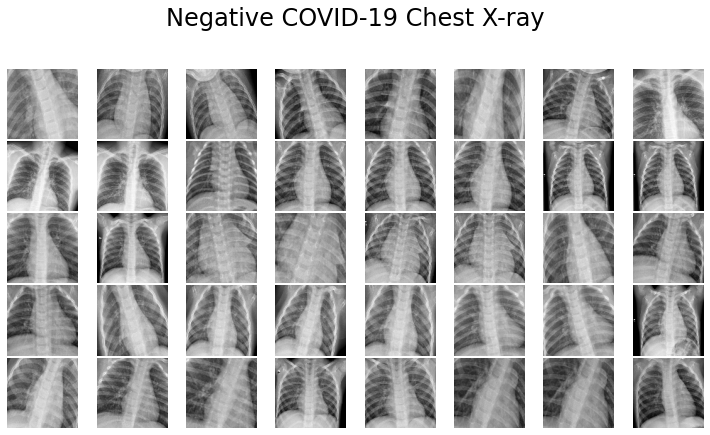

In [17]:

def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [18]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

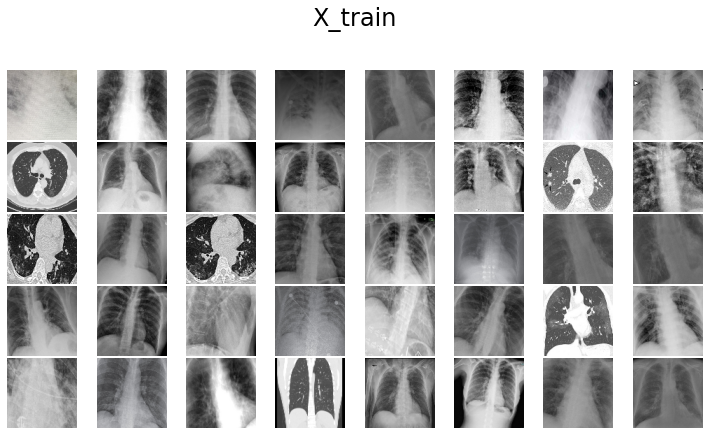

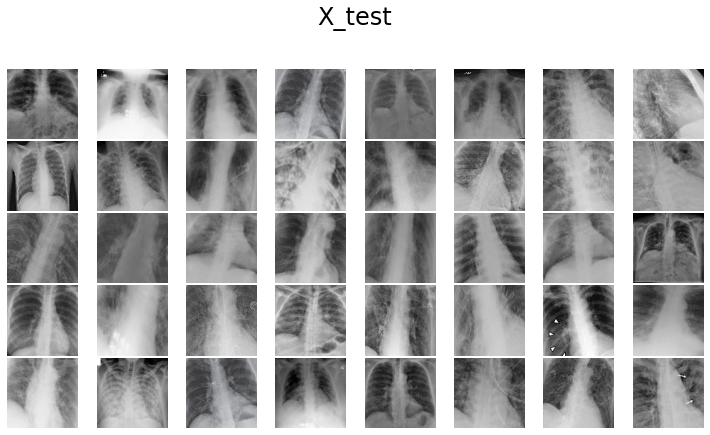

In [20]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [21]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=(100,100,3)
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[1,2,4]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp,out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100, 100, 384)     8448      
                                                                 
 conv2d_11 (Conv2D)          (None, 98, 98, 64)        221248    
                                                                 
 activation_2 (Activation)   (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 activation_3 (Activation)   (None, 47, 47, 32)        0         
                                                      

In [22]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [31]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=30,
                    epochs=10)

Epoch 1/10
30/30 [==============================] - 169s 6s/step - loss: 0.6626 - accuracy: 0.5573 - val_loss: 0.6705 - val_accuracy: 0.5624
Epoch 2/10
30/30 [==============================] - 171s 6s/step - loss: 0.6841 - accuracy: 0.5469 - val_loss: 0.6752 - val_accuracy: 0.5686
Epoch 3/10
30/30 [==============================] - 172s 6s/step - loss: 0.6656 - accuracy: 0.5823 - val_loss: 0.6657 - val_accuracy: 0.5634
Epoch 4/10
30/30 [==============================] - 167s 6s/step - loss: 0.6710 - accuracy: 0.5906 - val_loss: 0.6540 - val_accuracy: 0.5665
Epoch 5/10
30/30 [==============================] - 165s 6s/step - loss: 0.6632 - accuracy: 0.5917 - val_loss: 0.6135 - val_accuracy: 0.5665
Epoch 6/10
30/30 [==============================] - 181s 6s/step - loss: 0.6329 - accuracy: 0.6042 - val_loss: 0.5550 - val_accuracy: 0.6372
Epoch 7/10
30/30 [==============================] - 181s 6s/step - loss: 0.6054 - accuracy: 0.6806 - val_loss: 0.5207 - val_accuracy: 0.8430
Epoch 8/10
30

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100, 100, 384)     8448      
                                                                 
 conv2d_11 (Conv2D)          (None, 98, 98, 64)        221248    
                                                                 
 activation_2 (Activation)   (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 activation_3 (Activation)   (None, 47, 47, 32)        0         
                                                      

In [33]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

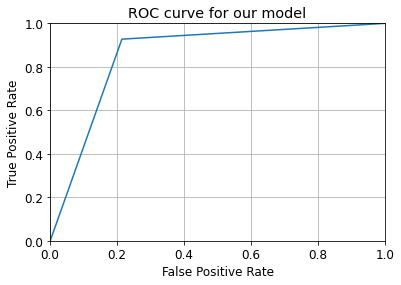

In [34]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


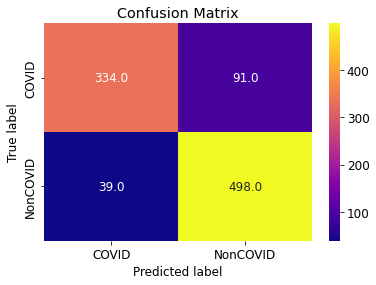

Confusion Matrix with Normalized Values


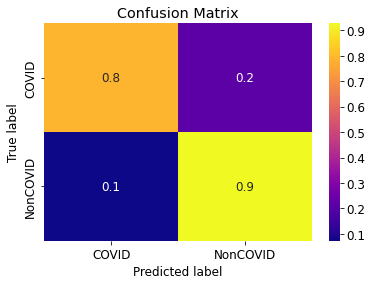

In [39]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',fmt=".1f",annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       425
           1       0.85      0.93      0.88       537

    accuracy                           0.86       962
   macro avg       0.87      0.86      0.86       962
weighted avg       0.87      0.86      0.86       962



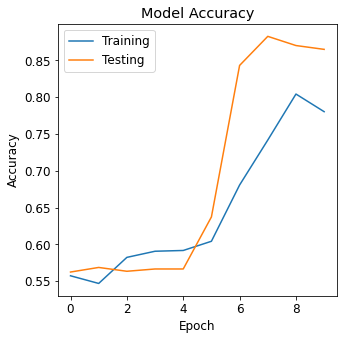

In [41]:
plt.figure(figsize=(5,5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

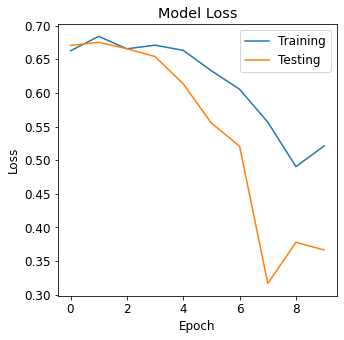

In [42]:
plt.figure(figsize=(5,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()